In [1]:
# Are we using a GPU? (if not & you're using Google Colab, go to Runtime -> Change Runtime Type -> Harware Accelerator: GPU )
!nvidia-smi

Tue May 17 16:25:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.13       Driver Version: 462.13       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 307... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8    15W /  N/A |    442MiB /  8192MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get data (10% of labels)
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [3]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [8]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

After setting up our data_augmentation model, time to put together a feature extraction transfer learning model. We will import the base model using the parameter <b>include_top = False </b> so we can add on our own output layers.

In [10]:
# setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images -> only happens during training
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number output as classes
model = tf.keras.Model(inputs, outputs)





In [11]:
# Get a summary of our model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Notice the only trainable parameters are within the <b>output_layer</b> which is exactly what we're after with this first run of feature extraction.

In [12]:
# Compile
model.compile(loss='categorical_crossentropy',
optimizer=tf.keras.optimizers.Adam(),
metrics=['accuracy'])

# Fit
history_all_classes_10_percent = model.fit(train_data_10_percent,
epochs=10,
validation_data=test_data,
validation_steps=int(0.15 * len(test_data))) # evaluating on small portion of test data

Epoch 1/10
24/24 [==============================] - 26s 602ms/step - loss: 1.9984 - accuracy: 0.3120 - val_loss: 1.5181 - val_accuracy: 0.6278
Epoch 2/10
24/24 [==============================] - 9s 367ms/step - loss: 1.3476 - accuracy: 0.6853 - val_loss: 1.1289 - val_accuracy: 0.7358
Epoch 3/10
24/24 [==============================] - 8s 325ms/step - loss: 1.0658 - accuracy: 0.7253 - val_loss: 0.9057 - val_accuracy: 0.7926
Epoch 4/10
24/24 [==============================] - 8s 322ms/step - loss: 0.9020 - accuracy: 0.7720 - val_loss: 0.8070 - val_accuracy: 0.7869
Epoch 5/10
24/24 [==============================] - 8s 341ms/step - loss: 0.7928 - accuracy: 0.7933 - val_loss: 0.7419 - val_accuracy: 0.7841
Epoch 6/10
24/24 [==============================] - 7s 297ms/step - loss: 0.7347 - accuracy: 0.8067 - val_loss: 0.6879 - val_accuracy: 0.8125
Epoch 7/10
24/24 [==============================] - 6s 253ms/step - loss: 0.6705 - accuracy: 0.8307 - val_loss: 0.6888 - val_accuracy: 0.7983
Epoch

In [13]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

79/79 [==============================] - 5s 67ms/step - loss: 0.5618 - accuracy: 0.8276


[0.5617727637290955, 0.8276000022888184]

### Fine-tuning 
Lets try fine-tune a few layers in the base model and see if we gain any improvements

In [14]:
# unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [17]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [18]:
# Make sure what layers we want are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [21]:
# Fine-tune f or 5 more epochs
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_10_percent,
epochs=fine_tune_epochs,
validation_data=test_data,
validation_steps=int(0.15 * len(test_data)),
initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 10/10
24/24 [==============================] - 15s 328ms/step - loss: 0.5144 - accuracy: 0.8653 - val_loss: 0.5838 - val_accuracy: 0.8097


In [22]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

79/79 [==============================] - 5s 57ms/step - loss: 0.5314 - accuracy: 0.8256


[0.5314407348632812, 0.8256000280380249]

## Visualizing predictions on test images

In [23]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    """Read in an image from filename, turn image to tensor and reshape to 224,224,3
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.io.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # rescale the image(get all values between 0 and 1)
        return img/255.
    else:
        return img 


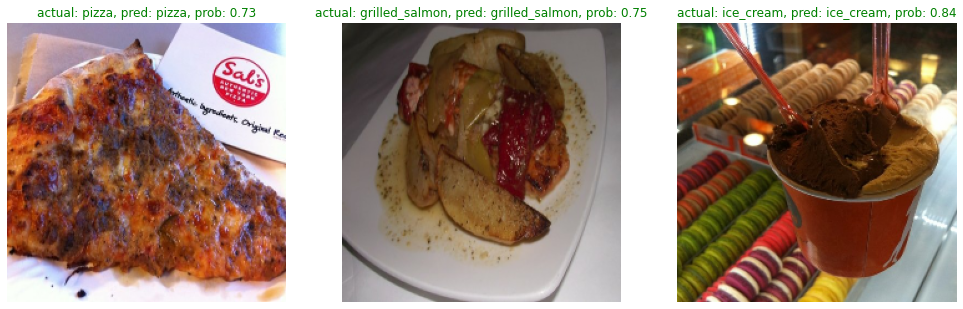

In [25]:
# Make predictions on series of random images
import os
import random
import matplotlib.pyplot as plt


plt.figure(figsize=(17,10))
for i in range(3):
    # choose a random image from a random class
    class_name = random.choice(test_data.class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = test_data.class_names[pred_prob.argmax()] # find the predicted class

    # plot the image(s)
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # change the color of text based on whether prediction is right or wrong
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False)


## test on your own images

In [ ]:
"""
img = load_and_prep_image(img, scale=False)
pred_prob = model.predict(tf.expand_dims(img, axis=0))
pred_class = class_names[pred_prob.argmax()]
# plot the image with appropriate annotations
plt.figure()
plt.imshow(img/255.)
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
plt.axis(False)
"""
